##### Import

In [1]:
## python import

import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as datetime
from scipy.stats import norm

###### Yahoo Down load

In [2]:

StartDate=datetime.datetime(2008,1,1)
EndDate=datetime.datetime.today()


In [3]:
StartDate

datetime.datetime(2008, 1, 1, 0, 0)

In [4]:
# yahoo datadown
VIX=yf.download('^vix',StartDate,EndDate)
SKEW=yf.download('^skew',StartDate,EndDate)
SPX=yf.download('^gspc',StartDate,EndDate)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
VIX.columns=['vix_high','vix_low','vix_open','vix_close','vix_volume','vix_adj_close']
SKEW.columns=['skew_high','skew_low','skew_open','skew_close','skew_volume','skew_adj_close']
SPX.columns=['spx_high','spx_low','spx_open','spx_close','spx_volume','spx_adj_close']

##### Save pd data to excel

In [6]:
cf=pd.concat([VIX,SKEW,SPX],axis=1)

In [7]:
cf.to_excel("cf.xlsx")

##### Load excel data

In [8]:
result=pd.read_excel("cf.xlsx")

In [9]:
Dates = result['Date']
results=result.iloc[:,1:]
results.index=Dates
resultss=results.fillna(method='ffill')
df=resultss

#####  Predict realized volatility with Intra information of high and low 

In [10]:
df['spx_hl']=np.power(np.log(df['spx_high'])-np.log(df['spx_low']),2)
df['spx_oc']=np.power((np.log(np.maximum(df['spx_open'],df['spx_close']))-np.log(np.minimum(df['spx_open'],df['spx_close']))),2)
df['spx_on']=np.power(df['spx_close'].pct_change(),2)
df['spx_vidl']=0.8*(df['spx_hl']-df['spx_oc'])+0.2*(df['spx_on'])
exp_weight=[0.00170074,0.00426233,0.00743368,0.01111781,0.01525666,0.0198101,0.0247481,0.03004702,0.0356876,0.04165371,0.04793159,0.05450928,0.06137628,0.06852326,0.07594184,0.08362446,0.09156423,0.09975485,0.10819051,0.11686595]
df['spx_vid']=df['spx_vidl'].rolling(len(exp_weight)).apply(lambda x:np.sqrt(np.sum(np.array(x)*np.array(exp_weight))*250),raw=True)
df['rv']=df['vix_close'].shift(0)/100-df['spx_vid']


##### Rolling data

In [11]:
df['spx_ret']=df['spx_close'].pct_change()
df['spx_r_vol']=df['spx_ret'].rolling(window=20).std()*np.sqrt(252)
df['vix_20_mov']=df['vix_close'].rolling(window=22).mean()
df['skew_20_mov']=df['skew_close'].rolling(window=22).mean()
df['spx_hvol']=df['spx_ret'].rolling(10).std()*np.sqrt(252)
df['hrv']=df['vix_close'].shift(1)/100-df['spx_hvol']
df['spx_ewma_vol']=df['spx_ret'].ewm(10).std()*np.sqrt(252)


In [12]:
df[['spx_hvol','spx_vid','spx_ewma_vol','vix_close']].tail(5)

,spx_hvol,spx_vid,spx_ewma_vol,vix_close
Date,,,,
2021-06-28,0.114957,0.033336,0.097938,15.76
2021-06-29,0.113930,0.032588,0.093533,16.02
2021-06-30,0.108084,0.032368,0.089181,15.83
2021-07-01,0.108604,0.033957,0.086966,15.48
2021-07-02,0.068380,0.039804,0.087280,15.07


##### Vix and Skew Signal

In [13]:
df['vix_rank']=df['vix_20_mov'].rolling(window=500).apply(lambda x:( x.rank(ascending=True)[-1])/500,raw=False)
df['skew_rank']=df['skew_20_mov'].rolling(window=500).apply(lambda x:( x.rank(ascending=True)[-1])/500,raw=False)

#### Trend Signal

In [14]:
df['vix_long_mov']=df['vix_close'].rolling(window=100).mean()
df['vix_short_mov']=df['vix_close'].rolling(window=5).mean()
df['vix_trend']=np.where(df['vix_long_mov']>df['vix_short_mov'],1,0)

#### HRV_Signal

In [15]:
df['hrv']=df['vix_close'].shift(1)/100-df['spx_hvol']
df['hrv_signal']=np.where(df['hrv']>0,1,0)

#### EWMA_Signal

<AxesSubplot:xlabel='Date'>

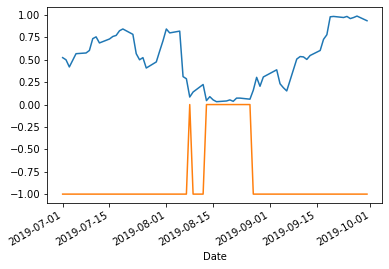

In [16]:
df['ewmav']=df['vix_close']/100-df['spx_hvol']

df['ewmav_rank']=df['ewmav'].rolling(window=250).apply(lambda x:( x.rank(ascending=True)[-1])/250,raw=False)
df['ewmav_rank'].loc['2019-07-01': '2019-09-30'].plot()
df['ewmav_signal']=np.where(df['ewmav_rank'] >= 0.1,-1,0)
df['ewmav_signal'].loc['2019-07-01': '2019-09-30'].plot()

#### RV_Signal

In [17]:
df['rv_signal']=np.where(df['rv']>0,1,0)

<AxesSubplot:xlabel='Date'>

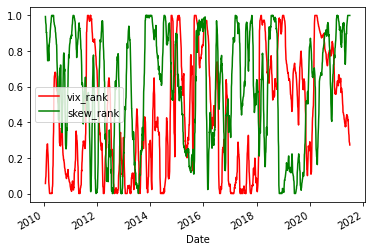

In [18]:
df.loc[:,['vix_rank','skew_rank']].plot(color='r''g', linestyle='-')

In [19]:
df[['vix_rank','skew_rank']].tail(5)

,vix_rank,skew_rank
Date,,
2021-06-28,0.288,1.0
2021-06-29,0.286,1.0
2021-06-30,0.284,1.0
2021-07-01,0.278,1.0
2021-07-02,0.274,1.0


#### Intra Signal

In [20]:
df['vix_2_mov']=df['vix_close'].rolling(window=2).mean()
scale_n=100
df['vol_scale']=df['vix_2_mov'].dropna().rolling(window=scale_n).apply(lambda x:( x.rank(ascending=True)[-1])/scale_n,raw=False)
df['intra_in_out']=np.where(df['vol_scale'] > 0.7,1,0)

##### Vix & Skew Signal

In [21]:

def vix_s(v,s):
    c=np.empty
    if v > 0.5 and s >0.5:
        c = 0 # 0.1
    elif v >0.5 and s <=0.75:
        c= -1.5  #9.5
    elif v<=0.5 and s > 0.5:
        c = -1
    elif v <=0.5 and s <= 0.5:
        c = -0.3
    else:
        c=0
    return c 
                        

In [22]:
def rt_s(r,t):
    c=np.empty
    if r >= 0 and t == 1:
        c = -0.4 # 0.1
    else:
        c= r
    return c 

In [23]:
df['vix_signal']=df.loc[:,['vix_rank','skew_rank']].dropna().apply(lambda x: vix_s(x[0],x[1]),axis=1)
df['rt_signal']=df.loc[:,['vix_signal','vix_trend']].dropna().apply(lambda x: rt_s(x[0],x[1]),axis=1)

In [24]:
#df['seokgoo_vix_signal']=df['rt_signal'].shift(1)
df['seokgoo_spx_signal']=df['rv_signal']*df['hrv_signal']
df['spx_intra_vol']=(df['spx_high']-df['spx_low'])/df['spx_close']
df['seokgoo_spx_intra_barri']=df['spx_intra_vol'].rolling(5).mean()*100*0.5

df['seokgoo_vix_signal']=df['ewmav_signal']
df['seokgoo_intra_in_out']=df['intra_in_out']
seokgoo=pd.concat([df['seokgoo_spx_signal'],df['seokgoo_vix_signal'],df['seokgoo_intra_in_out'],df['seokgoo_spx_intra_barri']],axis=1)
print(seokgoo.tail(2))

            seokgoo_spx_signal  seokgoo_vix_signal  seokgoo_intra_in_out  \
Date                                                                       
2021-07-01                   1                  -1                     0   
2021-07-02                   1                  -1                     0   

            seokgoo_spx_intra_barri  
Date                                 
2021-07-01                -0.134716  
2021-07-02                -0.173695  


#####  Return Simulation

In [25]:
df['spx_fut_ret']=df['spx_ret'].shift(-1)

In [26]:
C=df['rt_signal'].shift(1)*df['spx_fut_ret']*-1
C1=df['rv_signal'].shift(2)*df['spx_fut_ret']*df['hrv_signal'].shift(2)*2
#C1=(df['rv_signal'].shift(2)*df['skew_rank'].shift(2))*df['spx_fu_ret']*3#*df['ewmarv_signal'].shift(1)
#C1=df['hrv_signal'].shift(1)*df['spx_fu_ret']*5
CCC=(1+C).cumprod()
CCC1=(1+C1).cumprod()


<AxesSubplot:xlabel='Date'>

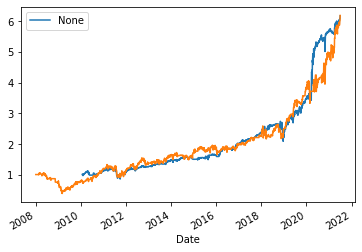

In [27]:
CCC.loc['2007-01-01':].plot(legend=True)
CCC1.loc['2007-01-01':].plot()

##### mean Reverstion Strategy

In [28]:
def mean_reverting(da,nday):
    import numpy as np
    ww=[]
    for i in range(nday):
        ww.append(i+1)
    da=np.array(da)
    weight=np.dot(da,ww)*-1*4
    #weight=np.where(weight<0,0,weight)
    return weight

In [29]:
ww=[]
for i in range(5):
    ww.append(i+1) 
ww

[1, 2, 3, 4, 5]

In [30]:
q=np.array(ww)

In [31]:
x=df['spx_ret'].tail(5).T
mean_reverting(x,5)

-0.26096412530198254

In [32]:
df['wei']=df['spx_ret'].dropna().rolling(10).apply(lambda x: mean_reverting(x,10),raw=False)

In [33]:
df['wei'].tail(5)

Date
2021-06-28   -0.504774
2021-06-29   -0.481714
2021-06-30   -0.491531
2021-07-01   -0.630214
2021-07-02   -0.837405
Name: wei, dtype: float64

<AxesSubplot:xlabel='Date'>

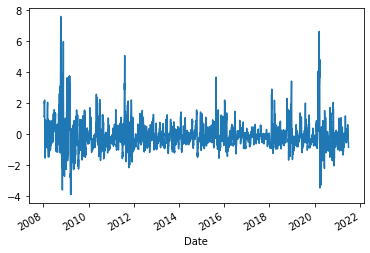

In [34]:
df['wei'].plot()

In [98]:
#sendtxt=seokgoo.columns.values.tolist()+seokgoo.tail(1).values.tolist()


In [106]:
txtcol=seokgoo.columns.values.tolist()
txtval=seokgoo.tail(1).values.tolist()

In [135]:
str(txtval[0][0])

In [128]:
import telepot

In [145]:
ma=txtcol[0]+':'+ str(txtval[0][0])+'\n'+txtcol[1]+':'+ str(txtval[0][1])+'\n'+txtcol[2]+':'+ str(txtval[0][2])+'\n'

In [146]:
bot=telepot.Bot(token='1869681798:AAHUK-pLER5Uah_xHYkD6TgUBgph8Aa2kkM')
id1='508255215'
id2='34316367'
id3='1524661832'

In [154]:
bot.sendMessage(id2,txtcol[0]+':'+ str(txtval[0][0])+'\n'+txtcol[1]+':'+ str(txtval[0][1])+'\n'+txtcol[2]+':'+ str(txtval[0][2])+'\n')

{'message_id': 34,
 'from': {'id': 1869681798,
  'is_bot': True,
  'first_name': 'Stone9',
  'username': 'Stone9_bot'},
 'chat': {'id': 34316367,
  'first_name': 'Seung Min',
  'last_name': 'Lee',
  'username': 'olguri',
  'type': 'private'},
 'date': 1625547397,
 'text': 'seokgoo_spx_signal:1.0\nseokgoo_vix_signal:-1.0\nseokgoo_intra_in_out:0.0'}